<a href="https://colab.research.google.com/github/Rithvik26/Main_project_Wild_Animals/blob/main/Main_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!unzip -u "/content/drive/MyDrive/Wild_Animals.zip" -d "/content/drive/MyDrive/Wild_Animals"

Archive:  /content/drive/MyDrive/Wild_Animals.zip


In [3]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import imutils
import os
import cv2
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer

import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
from sklearn.preprocessing import LabelBinarizer

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


In [4]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [5]:
data = []
lab = []
img_paths = []
classes=[ 'cheetah', 'fox', 'hyena','lion','tiger', 'wolf']

In [6]:
def make_dataframes(sdir):
    bad_images=[]
    classes=[ 'cheetah', 'fox', 'hyena','lion','tiger', 'wolf']
    filepaths=[]
    labels=[]
    data=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        subdir=os.listdir(classpath)[0]
        subpath=os.path.join(classpath,  subdir)
        if os.path.isdir(subpath):
            flist=sorted(os.listdir(subpath)) 
            for i in range (len(classes)):
                if classes[i] in classpath:
                    klass=classes[i]
            desc=f'{klass:10s}-{subdir:17s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(subpath,f)
                try: # test to ensure image files are valid image files
                    img=cv2.imread(fpath)
                    shape=img.shape
                    
                    filepaths.append(fpath) # only add valid image files to the dataframe
                    labels.append(klass)
                except:
                    bad_images.append(fpath)                    
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'/content/drive/MyDrive/Wild_Animals'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

wolf      -wolf-resize-512  : 100%|██████████████████████████████████████████████████████████| 263/263 [00:03<00:00, 81.53files/s]

number of classes in processed dataset=  6
718 <class 'int'>
the maximum files in any class in train_df is  718   the minimum files in any class in train_df is  525
train_df length:  3618   test_df length:  776   valid_df length:  775


In [7]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=500
min_samples=500
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  3618  with  6  classes
after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500
the trimmed dataframe now is of length  3000  with  6  classes


In [8]:
img_size=(224,224)
working_dir=r'/content/drive/MyDrive/Wild_Animals'

In [9]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

In [10]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps


batch_size=20
train_gen, test_gen, valid_gen, test_steps =make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 3000 validated image filenames belonging to 6 classes.
Found 775 validated image filenames belonging to 6 classes.
Found 776 validated image filenames belonging to 6 classes.
test batch size:  8   test steps:  97  number of classes :  6


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


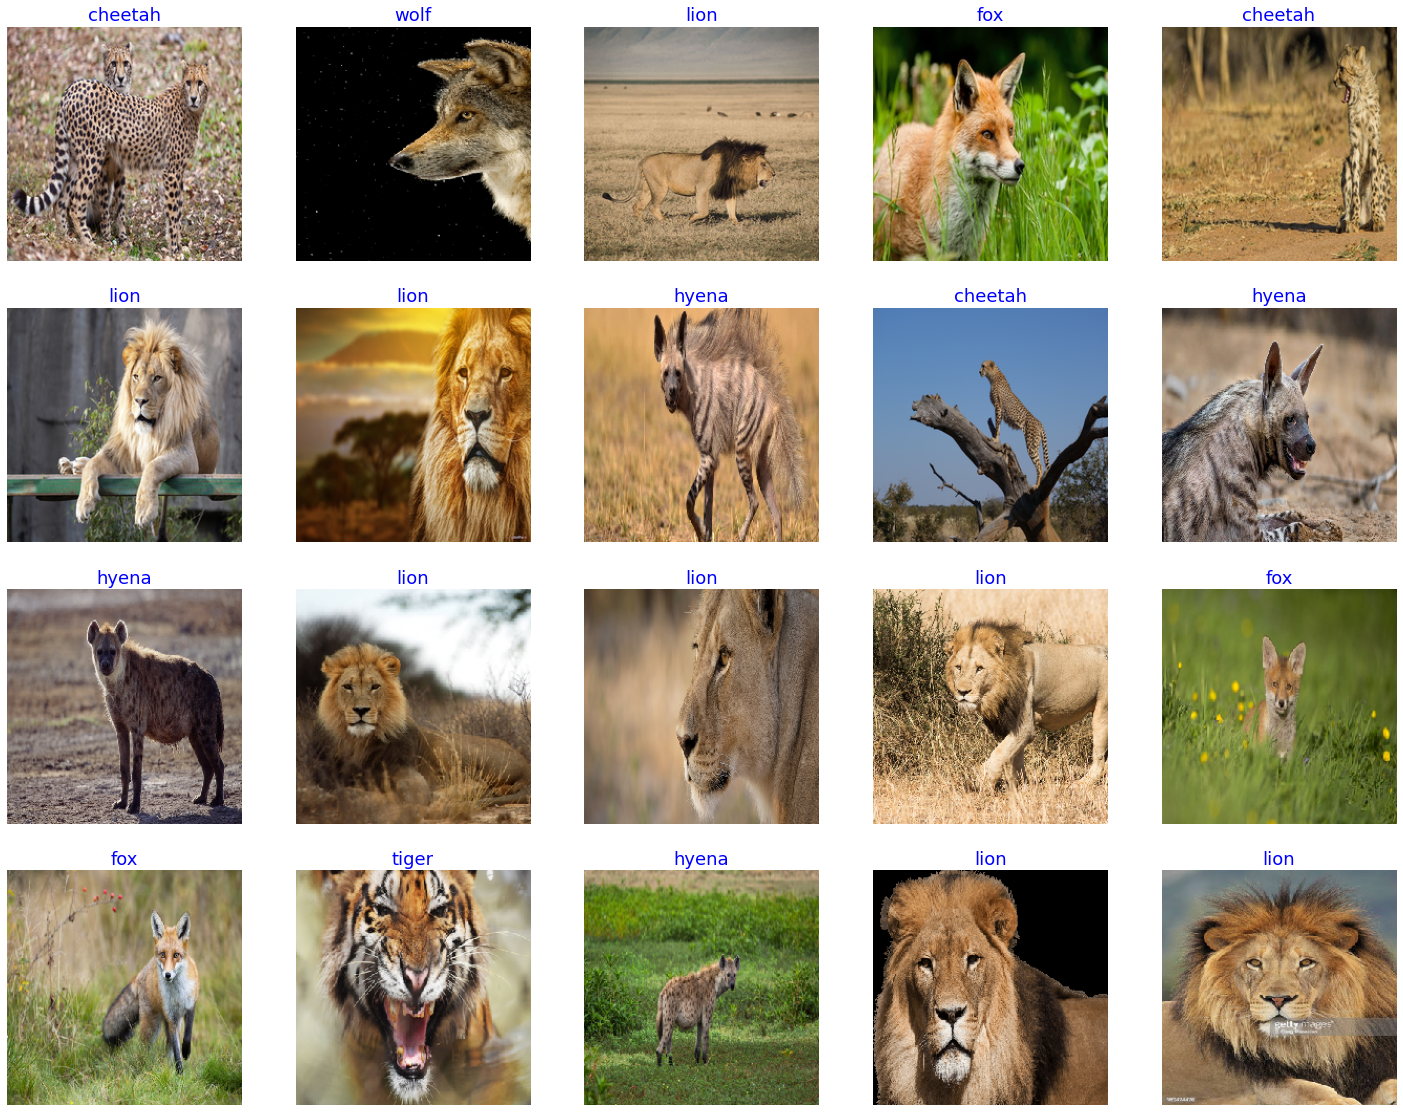

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

In [12]:
d={'hyena':0, 'tiger':1, 'fox':3, 'wolf':4, 'cheetah':2, 'lion':5}

In [13]:
from skimage.feature import hog

def hog_data_extractor(jpeg_path):
    jpeg_data = cv2.imread(jpeg_path)
    jpeg_data=cv2.resize(jpeg_data,(150,150)) 
    hog_data = hog(jpeg_data)/255.0
    return hog_data

In [14]:
def img_lab(df):
  images=[]
  labels=[]
  images2=[]
  IMAGE_SIZE = (150, 150)
  for ind in df.index:
    img_path = df['filepaths'][ind]
    image = cv2.imread(img_path)
    image = cv2.resize(image, IMAGE_SIZE) 
    images.append(image)
    images2.append(hog_data_extractor(img_path))
    labels.append(df['labels'][ind])  
  return images,images2,labels


In [15]:


images,images2,labels = img_lab(train_df)
train_images = np.array(images, dtype = 'float32')
train_labels = np.array(labels)  
train2_images = np.array(images2, dtype = 'float32')
train2_labels = np.array(labels)    


In [16]:
images,images2,labels = img_lab(test_df)
test_images = np.array(images, dtype = 'float32')
test_labels = np.array(labels)   
test2_images = np.array(images2, dtype = 'float32')
test2_labels = np.array(labels)   


In [17]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
IMAGE_SIZE = (150, 150)
print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 3000
Number of testing examples: 776
Each image is of size: (150, 150)


In [18]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(150, 150, 3)))

In [20]:
train_images[0].shape

(150, 150, 3)

In [21]:
lr = 0.001
epochs = 5
batch_size = 128
losses = {
    "class_label": "categorical_crossentropy",
}


In [22]:
trainTargets = {
    "class_label": train_labels,
}
testTargets = {
    "class_label": test_labels,
}

In [23]:

layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
outputa = layer_dict['block2_pool'].output
m1 = Model(inputs=vgg.input, outputs=outputa)

flatten = m1.output
flatten = Flatten()(flatten)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [24]:
m1 = Model(
    inputs=m1.input,
    outputs=(softmaxHead))

In [25]:
model_path = "model1.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [26]:
opt = Adam(lr)
m1.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [27]:
d2={}
a2={}
from time import time
st=time()
H1 = m1.fit(
    train_images, trainTargets,
    validation_data=(test_images, testTargets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)
d2["CNN1"]=(time()-st)
a2["CNN1"]=H1.history["val_accuracy"][-1]

Epoch 1/5
24/24 [==============================] - 29s 849ms/step - loss: 14921.2998 - accuracy: 0.1857 - val_loss: 2.3361 - val_accuracy: 0.2126
Epoch 2/5
24/24 [==============================] - 11s 470ms/step - loss: 2.0092 - accuracy: 0.1927 - val_loss: 1.8197 - val_accuracy: 0.2023
Epoch 3/5
24/24 [==============================] - 11s 459ms/step - loss: 1.7991 - accuracy: 0.1837 - val_loss: 1.8046 - val_accuracy: 0.1714
Epoch 4/5
24/24 [==============================] - 11s 464ms/step - loss: 1.7934 - accuracy: 0.1773 - val_loss: 1.7977 - val_accuracy: 0.1765
Epoch 5/5
24/24 [==============================] - 11s 467ms/step - loss: 1.7854 - accuracy: 0.1893 - val_loss: 1.7883 - val_accuracy: 0.1778


In [28]:
layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
outputa = layer_dict['block4_pool'].output
m2 = Model(inputs=vgg.input, outputs=outputa)

flatten = m2.output
flatten = Flatten()(flatten)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [29]:
m2 = Model(
    inputs=m2.input,
    outputs=(softmaxHead))

In [30]:
model_path = "model1.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [31]:
opt = Adam(0.01)
m2.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [32]:
st=time()
H2 = m2.fit(
    train_images, trainTargets,
    validation_data=(test_images, testTargets),
    batch_size=32,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)
d2["CNN2"]=(time()-st)
a2["CNN2"]=H2.history["val_accuracy"][-1]

Epoch 1/5
94/94 [==============================] - 30s 267ms/step - loss: 298468.2812 - accuracy: 0.1693 - val_loss: 1.7912 - val_accuracy: 0.1985
Epoch 2/5
94/94 [==============================] - 20s 211ms/step - loss: 1.7927 - accuracy: 0.1513 - val_loss: 1.7924 - val_accuracy: 0.1443
Epoch 3/5
94/94 [==============================] - 20s 211ms/step - loss: 1.7927 - accuracy: 0.1463 - val_loss: 1.7911 - val_accuracy: 0.1985
Epoch 4/5
94/94 [==============================] - 20s 211ms/step - loss: 1.7929 - accuracy: 0.1597 - val_loss: 1.7909 - val_accuracy: 0.1714
Epoch 5/5
94/94 [==============================] - 21s 220ms/step - loss: 1.7933 - accuracy: 0.1603 - val_loss: 1.7915 - val_accuracy: 0.1559


In [33]:
from sklearn.model_selection import cross_val_score
from skimage import feature, color, data

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

In [34]:
def hog_data_extractor(jpeg_path):
    jpeg_data = cv2.imread(jpeg_path)
    jpeg_data=cv2.resize(jpeg_data,(150,150)) 
    hog_data = feature.hog(jpeg_data)/255.0
    return hog_data

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train2_labels)
y_test = le.fit_transform(test2_labels)

In [36]:
lsvc = LinearSVC(random_state=0,tol=1e-5)
st=time()
lsvc.fit(train2_images,y_train)
d2["Linear_SVM"]=(time()-st)
print('Coef',lsvc.coef_)
print('Intercept',lsvc.intercept_)

Coef [[ 0.00168728  0.00043656 -0.01355811 ...  0.0425238   0.06733603
   0.03390344]
 [ 0.02046802 -0.02221304 -0.00542593 ... -0.00503154  0.02564141
  -0.02071345]
 [-0.01352647  0.02264307  0.03935163 ...  0.02262412 -0.01015885
   0.02334945]
 [-0.05840143 -0.03799266 -0.03332033 ...  0.01754753  0.03157978
   0.02477442]
 [ 0.00807363  0.02000914  0.00558377 ... -0.038989   -0.04922592
  -0.01096271]
 [ 0.03991237  0.01632908  0.00663221 ... -0.03967671 -0.06616969
  -0.05141134]]
Intercept [-0.72635668 -0.58002182 -0.77022591 -0.59658479 -0.66650194 -0.65110063]


In [37]:
import warnings
warnings.filterwarnings('ignore')

lsvc_score = lsvc.score(test2_images,y_test)
print('Accuracy', lsvc_score)
a2["Linear_SVM"]=lsvc_score
kfold = KFold(n_splits=10)


Accuracy 0.4420103092783505


In [38]:
!pip install -U efficientnet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import efficientnet.keras as effnet


In [40]:
from keras import applications
#from efficientnet import EfficientNetB3
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


efficient_net = effnet.EfficientNetB3(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 1536)             10783528  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 120)               184440    
                                                                 
 dense_3 (Dense)             (None, 1)                 121       
                                                                 
Total params: 10,968,089
Trainable params: 10,880,793
Non-trainable params: 87,296
_________________________________________________________________


In [41]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
st=time()
H3 = model.fit_generator(
    train_gen,
    epochs = 5,
    steps_per_epoch = 10,
    validation_data = test_gen,
    validation_steps = 7
)
d2["Efficient_Net_B3"]=(time()-st)
a2["Efficient_Net_B3"]=H3.history["val_accuracy"][-1]

Epoch 1/5
10/10 [==============================] - 36s 820ms/step - loss: 2.4347 - accuracy: 0.6767 - val_loss: 67.8356 - val_accuracy: 0.8214
Epoch 2/5
10/10 [==============================] - 5s 455ms/step - loss: 0.5961 - accuracy: 0.8200 - val_loss: 7.3262 - val_accuracy: 0.8095
Epoch 3/5
10/10 [==============================] - 5s 454ms/step - loss: 0.5046 - accuracy: 0.8200 - val_loss: 10.0774 - val_accuracy: 0.8333
Epoch 4/5
10/10 [==============================] - 5s 447ms/step - loss: 0.4773 - accuracy: 0.8300 - val_loss: 4.6553 - val_accuracy: 0.8333
Epoch 5/5
10/10 [==============================] - 5s 455ms/step - loss: 0.4622 - accuracy: 0.8333 - val_loss: 3.1031 - val_accuracy: 0.8333


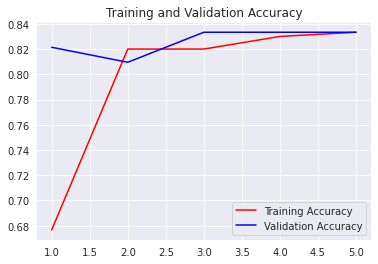

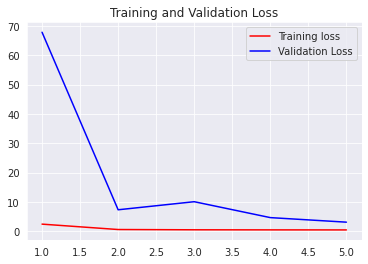

In [43]:
acc = H3.history['accuracy']
val_acc = H3.history['val_accuracy']
loss = H3.history['loss']
val_loss = H3.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [44]:
efficient_net = effnet.EfficientNetB0(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

16804768/16804768 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 120)               153720    
                                                                 
 dense_5 (Dense)             (None, 1)                 121       
                                                                 
Total params: 4,203,405
Trainable params: 4,161,389
Non-trainable params: 42,016
_________________________________________________________________


In [45]:
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
#binary_crossentropy

In [46]:
st=time()
H4 = model.fit_generator(
    train_gen,
    epochs = 5,
    steps_per_epoch = 20,
    validation_data = test_gen,
    validation_steps = 5
)
d2["Efficient_Net_B0"]=(time()-st)
a2["Efficient_Net_B0"]=H4.history["val_accuracy"][-1]

Epoch 1/5
20/20 [==============================] - 17s 336ms/step - loss: 3.3611 - accuracy: 0.7467 - val_loss: 370894.4688 - val_accuracy: 0.8333
Epoch 2/5
20/20 [==============================] - 5s 247ms/step - loss: 0.4678 - accuracy: 0.8333 - val_loss: 2132.0317 - val_accuracy: 0.8333
Epoch 3/5
20/20 [==============================] - 7s 327ms/step - loss: 0.4634 - accuracy: 0.8333 - val_loss: 37.3587 - val_accuracy: 0.8333
Epoch 4/5
20/20 [==============================] - 5s 238ms/step - loss: 0.4553 - accuracy: 0.8333 - val_loss: 7.2320 - val_accuracy: 0.8333
Epoch 5/5
20/20 [==============================] - 5s 236ms/step - loss: 0.4524 - accuracy: 0.8333 - val_loss: 0.8934 - val_accuracy: 0.8333


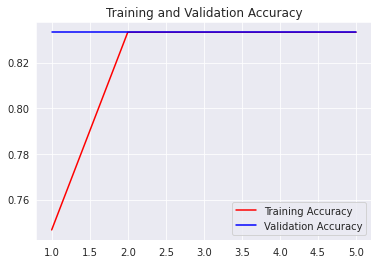

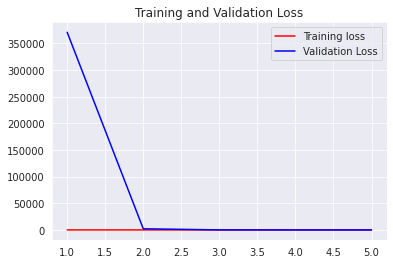

In [47]:
acc = H4.history['accuracy']
val_acc = H4.history['val_accuracy']
loss = H4.history['loss']
val_loss = H4.history['val_loss']
epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

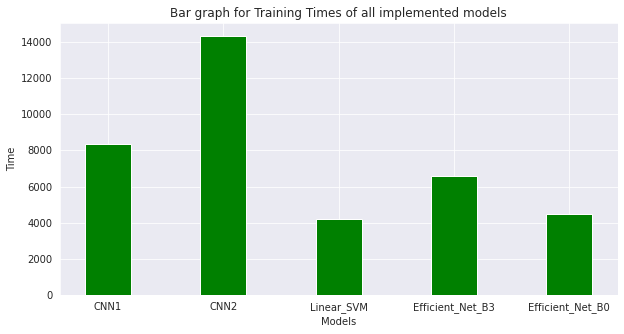

In [48]:
models = list(d2.keys())
accuracies = [100*i for i in d2.values()]
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, accuracies, color ='green',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Bar graph for Training Times of all implemented models")
plt.show()

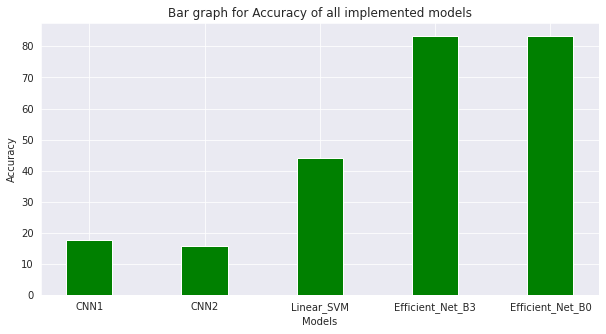

In [49]:
models = list(a2.keys())
accuracies = [100*i for i in a2.values()]
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, accuracies, color ='green',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Bar graph for Accuracy of all implemented models")
plt.show()